In [1]:
#librerias Keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad, rmsprop
from keras.layers import LSTM, GRU
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from utils.multi_gpu import make_parallel
from dataset.dataset import leer
from keras.utils.np_utils import to_categorical

### Cargar Datos
___

In [3]:
%%time
URL='data/'
Xtr,Ytr,Xt,Yt,Xv,Yv = leer(URL)
#Datos de entrenamiento
X_train = Xtr.reshape((Xtr.shape[0],32,32,3))
X_train = X_train.transpose([0, 3, 2, 1]) 
Y_train = to_categorical(Ytr, 10)
#Datos de Test
X_test  = Xt.reshape((Xt.shape[0],32,32,3))
X_test  = X_test.transpose([0, 3, 2, 1])
Y_test  = to_categorical(Yt, 10)
#Datos de Validación
X_val   = Xv.reshape((Xv.shape[0],32,32,3))
X_val   = X_val.transpose([0, 3, 2, 1])
Y_val   = to_categorical(Yv, 10)

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_val   = X_val.astype('float32')

CPU times: user 825 ms, sys: 609 ms, total: 1.43 s
Wall time: 1.43 s


In [4]:
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)
(50000, 10)
(10000, 10)


In [5]:
_size, n_channels, n_rows, n_cols = X_train.shape
n_classes = 10

Objetivo
-----

**(f)**Algunos investigadores, han propuesto que las capas de pooling se pueden reemplazar por capas convoluciones con stride 2. **¿Se reduce dimensionalidad de este modo?** Compruebelo verificando los cambios de forma (dimensionalidad) que experimenta un patron de entrada a medida que se ejecuta un forward-pass. Entrene la red resultante con el metodo que prefiera, graficando los errores de entrenamiento, validacion y pruebas como funcion del numero de “epochs” (fijando el maximo en un numero razonable como T = 25).

In [9]:
model = Sequential()
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(n_channels, n_rows, n_cols)))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), strides=(2, 2), padding='valid'))
#model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), strides=(2, 2), padding='valid'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(n_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 32, 32)        1792      
_________________________________________________________________
activation_14 (Activation)   (None, 64, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 15, 15)        36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 15, 15)        36928     
_________________________________________________________________
activation_15 (Activation)   (None, 64, 15, 15)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 7, 7)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
__________

Si bien el efecto de reducción de dimencionalidad se puede visualizar por ejemplo en que el flujo de las dimensiones en el modelo de parte (b) **es 32-32-16-16-16-8**, al reemplazar la capa de pooling por capas convoluciones de stride 2 el modelo tiene la forma de **32-32-15-15-15-7** podemos ver que la reducción de dimencionalidad no es la mitad como en el caso de capa de pooling.

In [10]:
#opt  = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
#opt = rmsprop(lr=0.001, decay=1e-6)
opt = 'adam'

In [11]:
epochs = 25
batch_size= 400

Con el paso que viene a continuación, logramos que todas las operaciones sobre el modelo pasen de ejecutarse en una GPU, a un esquema paralelo multi-GPU. Esto se verá reflejado en los tiempos de fit, registrados en los notebook.  

In [12]:
model = make_parallel(model, 8)

/home/ubuntu/Tarea/parte1/utils/multi_gpu.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged.append(merge(outputs, mode='concat', concat_axis=0))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/Tarea/parte1/utils/multi_gpu.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  return Model(input=model.inputs, output=merged)


In [13]:
#model.compile(loss='binary_crossentropy', optimizer=opt,  metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer=opt,  metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

In [14]:
%%time
history_categorical_crossentropy = model.fit(X_train, Y_train,batch_size=batch_size,nb_epoch=epochs,verbose=0,
          validation_data=(X_test, Y_test),shuffle=True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


CPU times: user 10min 25s, sys: 3min 55s, total: 14min 21s
Wall time: 2min 50s


### Comentarios
---

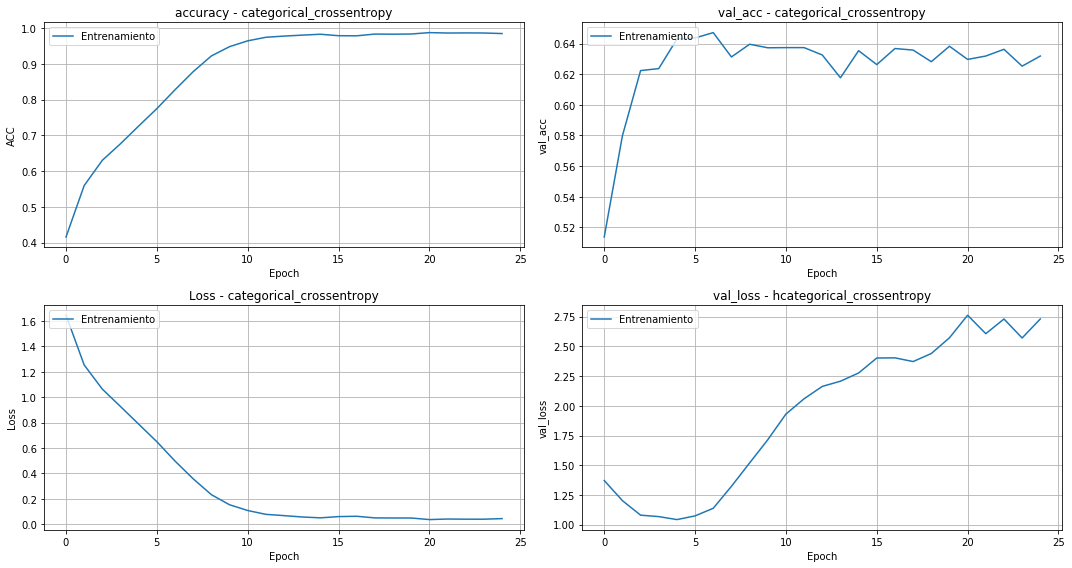

In [17]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(history_categorical_crossentropy.history['acc'])  
plt.title('accuracy - categorical_crossentropy')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento'], loc='upper left')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history_categorical_crossentropy.history['val_acc'])  
plt.title('val_acc - categorical_crossentropy')  
plt.ylabel('val_acc')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento'], loc='upper left')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(history_categorical_crossentropy.history['loss'])  
plt.title('Loss - categorical_crossentropy')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento'], loc='upper left')
plt.grid(True)


plt.subplot(2, 2, 4)
plt.plot(history_categorical_crossentropy.history['val_loss'])  
plt.title('val_loss - hcategorical_crossentropy')  
plt.ylabel('val_loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

Otro resultado de el cambio de la capa de pooling, es un comportamiento de la cuerva de aprendizaje mucho mas irregular de los datos de validación. Además el acurracy disminuye manteniendo la función de perdida (categorical crossentropy) y el optimizador (rmsprop)  pasamos de un 67.67% del caso anterior a un 63.19%

In [21]:
#%%time
scores = model.evaluate(X_val, Y_val)
print("")
print("Accuracy del modelo con Binary Crossentropy : %.2f%%" % (scores[1]*100))
print("Loss del modelo con Binary Crossentropy: %.2f%%" % (scores[0]*100))

 9984/10000 [============================>.] - ETA: 0s